In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


### 构建FaceNet中的Inception模型

In [2]:
def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

In [3]:
# Implementation of an inception block
def inception_block_1a(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name ='inception_3a_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3a_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    
    X_5x5 = Conv2D(16, (1, 1), data_format='channels_first', name='inception_3a_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(32, (5, 5), data_format='channels_first', name='inception_3a_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3a_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)
        
    # CONCAT
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_1b(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name='inception_3b_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3b_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3b_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(64, (5, 5), data_format='channels_first', name='inception_3b_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_1c(X):
    X_3x3 = conv2d_bn(X,
                      layer='inception_3c_3x3',
                      cv1_out=128,
                      cv1_filter=(1, 1),
                      cv2_out=256,
                      cv2_filter=(3, 3),
                      cv2_strides=(2, 2),
                      padding=(1, 1))

    X_5x5 = conv2d_bn(X,
                      layer='inception_3c_5x5',
                      cv1_out=32,
                      cv1_filter=(1, 1),
                      cv2_out=64,
                      cv2_filter=(5, 5),
                      cv2_strides=(2, 2),
                      padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_2a(X):
    X_3x3 = conv2d_bn(X,
                      layer='inception_4a_3x3',
                      cv1_out=96,
                      cv1_filter=(1, 1),
                      cv2_out=192,
                      cv2_filter=(3, 3),
                      cv2_strides=(1, 1),
                      padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                      layer='inception_4a_5x5',
                      cv1_out=32,
                      cv1_filter=(1, 1),
                      cv2_out=64,
                      cv2_filter=(5, 5),
                      cv2_strides=(1, 1),
                      padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                       layer='inception_4a_pool',
                       cv1_out=128,
                       cv1_filter=(1, 1),
                       padding=(2, 2))
    X_1x1 = conv2d_bn(X,
                      layer='inception_4a_1x1',
                      cv1_out=256,
                      cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_2b(X):
    #inception4e
    X_3x3 = conv2d_bn(X,
                      layer='inception_4e_3x3',
                      cv1_out=160,
                      cv1_filter=(1, 1),
                      cv2_out=256,
                      cv2_filter=(3, 3),
                      cv2_strides=(2, 2),
                      padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                      layer='inception_4e_5x5',
                      cv1_out=64,
                      cv1_filter=(1, 1),
                      cv2_out=128,
                      cv2_filter=(5, 5),
                      cv2_strides=(2, 2),
                      padding=(2, 2))
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_3a(X):
    X_3x3 = conv2d_bn(X,
                      layer='inception_5a_3x3',
                      cv1_out=96,
                      cv1_filter=(1, 1),
                      cv2_out=384,
                      cv2_filter=(3, 3),
                      cv2_strides=(1, 1),
                      padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                       layer='inception_5a_pool',
                       cv1_out=96,
                       cv1_filter=(1, 1),
                       padding=(1, 1))
    X_1x1 = conv2d_bn(X,
                      layer='inception_5a_1x1',
                      cv1_out=256,
                      cv1_filter=(1, 1))

    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

def inception_block_3b(X):
    X_3x3 = conv2d_bn(X,
                      layer='inception_5b_3x3',
                      cv1_out=96,
                      cv1_filter=(1, 1),
                      cv2_out=384,
                      cv2_filter=(3, 3),
                      cv2_strides=(1, 1),
                      padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                       layer='inception_5b_pool',
                       cv1_out=96,
                       cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_pool)

    X_1x1 = conv2d_bn(X,
                      layer='inception_5b_1x1',
                      cv1_out=256,
                      cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

In [4]:
# Implementation of the Inception model used for FaceNet
def faceRecoModel(input_shape):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)
    
    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)
    
    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='FaceRecoModel')
        
    return model

In [5]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [6]:
# 模型结构
FRmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 102, 102)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

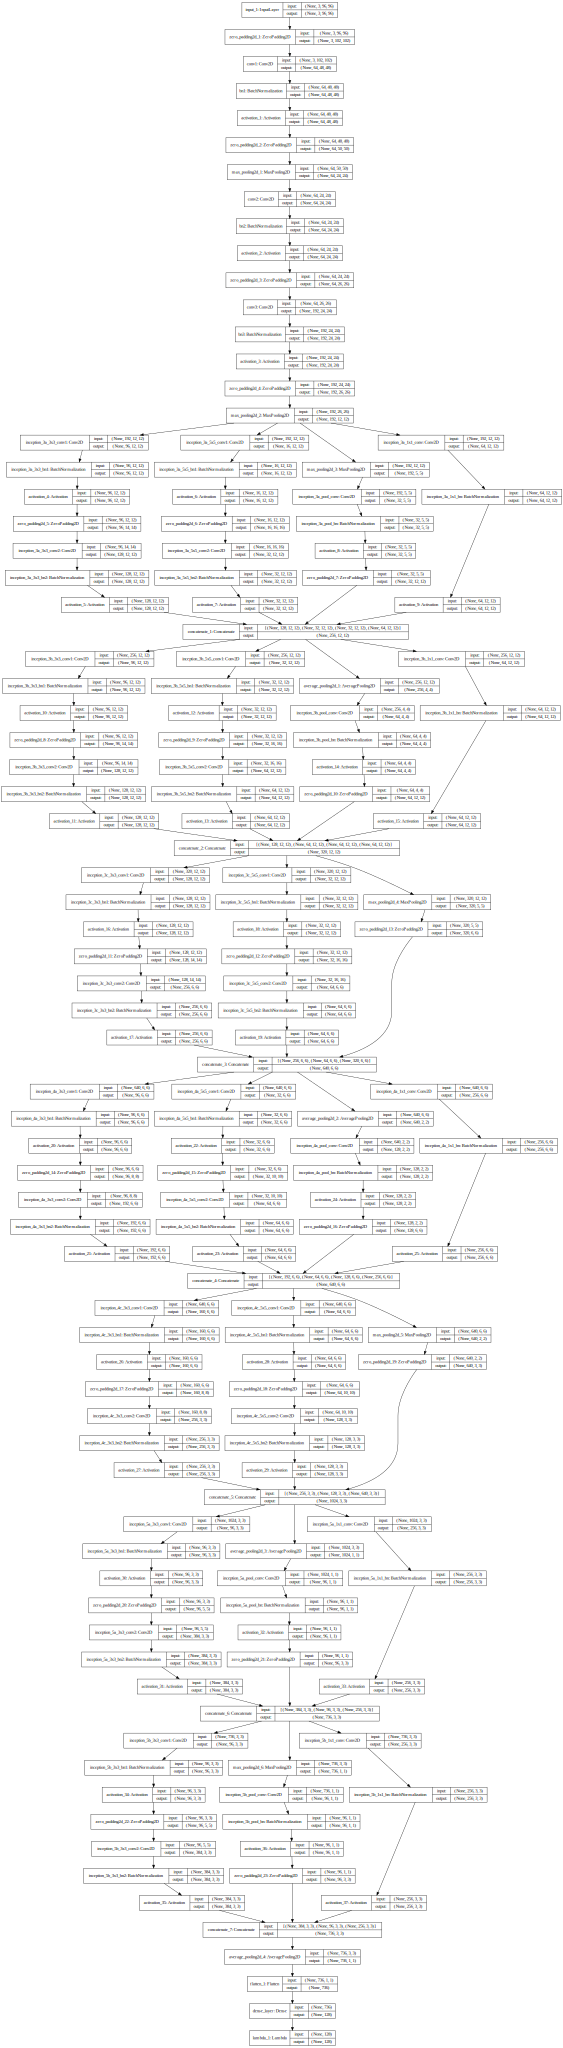

In [7]:
# 模型结构图
SVG(model_to_dot(FRmodel, show_shapes=True).create(prog='dot', format='svg'))

### 定义三元组损失函数 Triplet Loss

For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.

<img src="images/f_x.png" style="width:380px;height:150px;">

<!--
We will also add a normalization step at the end of our model so that $\mid \mid f(x) \mid \mid_2 = 1$ (means the vector of encoding should be of norm 1).
!-->

Training will use triplets of images $(A, P, N)$:  

- A is an "Anchor" image--a picture of a person. 
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

<img src="images/triplet_comparison.png" style="width:280px;height:150px;">
<br>

Implement the triplet loss as defined by formula (3). Here are the 4 steps:
1. Compute the distance between the encodings of "anchor" and "positive": $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
2. Compute the distance between the encodings of "anchor" and "negative": $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
3. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
3. Compute the full formula by taking the max with zero and summing over the training examples:
$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ \tag{3}$$

In [8]:
# Implementation of the triplet loss as defined by formula (3)
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum((anchor - positive)**2, axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum((anchor - negative)**2, axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

In [9]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

### 载入预先训练好的参数

In [10]:
WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

In [11]:
conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

In [12]:
def load_weights():
    # Set weights path
    dirPath = './weights'
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS:
        if 'conv' in name:
            conv_w = np.genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = np.genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
        elif 'bn' in name:
            bn_w = np.genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = np.genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = np.genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = np.genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = np.genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = np.genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict

In [13]:
def load_weights_from_FaceNet(FRmodel):
    # Load weights from csv files (which was exported from Openface torch model)
    weights = WEIGHTS
    weights_dict = load_weights()

    # Set layer weights of the model
    for name in weights:
        if FRmodel.get_layer(name) != None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])
        elif model.get_layer(name) != None:
            model.get_layer(name).set_weights(weights_dict[name])

In [14]:
# Load a previously trained model.This might take a couple of minutes to run.
load_weights_from_FaceNet(FRmodel)

### 构建人脸数据库

In [15]:
identities = ["danielle", "younes", "tian", "andrew", "kian", "dan", "sebastiano", "bertrand", "kevin", "felix", "benoit", "arnaud"]
files = ["danielle.png", "younes.jpg", "tian.jpg", "andrew.jpg", "kian.jpg", "dan.jpg", "sebastiano.jpg", 
          "bertrand.jpg", "kevin.jpg", "felix.jpg", "benoit.jpg", "arnaud.jpg"]

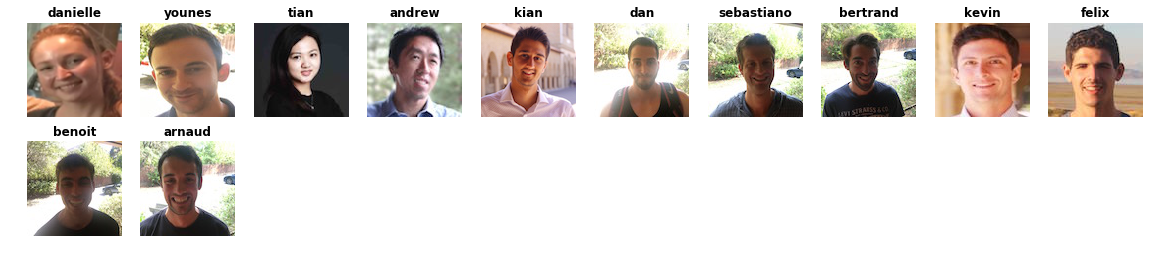

In [16]:
images = {}
row = 10
col = np.ceil(len(identities) / row)
plt.figure(figsize=(20, 20 * col / row))
for i, identity  in enumerate(identities):
    img1 = cv2.imread(os.path.join("images", files[i]), 1)
    img = img1[...,::-1]
    images[identity] = img
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.title("%s" % identity, fontweight='bold')

In [17]:
def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

In [18]:
# This database maps each person's name to a 128-dimensional encoding of their face.
database = {}
for identity, file in zip(identities, files):
    database[identity] = img_to_encoding(os.path.join("images", file), FRmodel)

### 人脸验证 Face Verification

In [19]:
# Function that verifies if the person on the "image_path" image is "identity".
def verify(image_path, identity, database, model):
    # Step 1: Compute the encoding for the image.
    encoding = img_to_encoding(image_path, FRmodel)
    
    # Step 2: Compute distance with identity's image
    dist = np.sum((encoding - database[identity])**2)
    
    # Step 3: Open the door if dist < 0.7, else don't open
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    
    # show "identity" image
    plt.figure(figsize=(20, 2))
    plt.subplot(1, 10, 1)
    plt.imshow(images[identity], interpolation='nearest')
    plt.axis('off')
    plt.title("%s" % identity, fontweight='bold')
    
    # show "image_path" image
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    plt.subplot(1, 10, 2)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.title("[camera]", fontweight='bold')
        
    return dist, door_open

It's younes, welcome home!


(0.43478793, True)

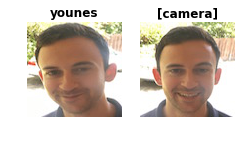

In [20]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

It's not kian, please go away


(0.7434876, False)

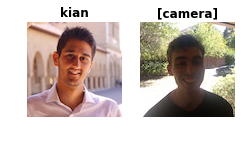

In [21]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

### 人脸识别 Face Recognition

In [22]:
# Implements face recognition for the happy house by finding who is the person on the image_path image.
def who_is_it(image_path, database, model):
    ## Step 1: Compute the target "encoding" for the image.## 
    encoding = img_to_encoding(image_path, FRmodel)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database.
        dist = np.sum((encoding - db_enc)**2)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))

    # show "identity" image
    plt.figure(figsize=(20, 2))
    plt.subplot(1, 10, 1)
    plt.imshow(images[identity], interpolation='nearest')
    plt.axis('off')
    plt.title("%s" % identity, fontweight='bold')
        
    # show "image_path" image
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    plt.subplot(1, 10, 2)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.title("[camera]", fontweight='bold')
        
    return min_dist, identity

it's benoit, the distance is 0.05379177


(0.05379177, 'benoit')

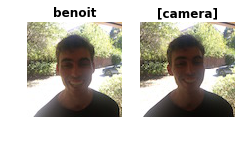

In [23]:
who_is_it("images/camera_2.jpg", database, FRmodel)

it's bertrand, the distance is 0.12618017


(0.12618017, 'bertrand')

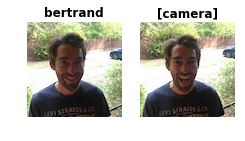

In [24]:
who_is_it("images/camera_3.jpg", database, FRmodel)

it's dan, the distance is 0.06273374


(0.06273374, 'dan')

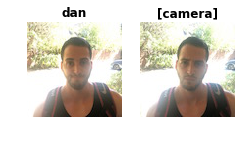

In [25]:
who_is_it("images/camera_4.jpg", database, FRmodel)